In [12]:
%matplotlib inline

In [10]:
import msprime
import numpy as np
import seaborn as sns

from IPython.display import SVG


## Basic examples

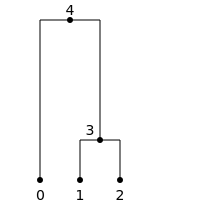

In [7]:
ts = msprime.simulate(3, Ne=0.5)
tree = next(ts.trees())
SVG(tree.draw())

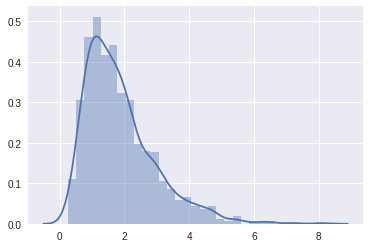

In [17]:
N = 1000
T_mrca = np.zeros(N)
for j, ts in enumerate(msprime.simulate(10, Ne=0.5, num_replicates=N)):
    tree = next(ts.trees())
    T_mrca[j] = tree.time(tree.root)
sns.distplot(T_mrca);    